Processing...
Done!


Dataset: Cora
-----------------------
Number of graphs: 1
Number of nodes (papers): 2708
Number of edges (citations): 10556
Number of features per node (word vector): 1433
Number of classes (paper topics): 7

Inspect the data object:
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
------------------------------------------
GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)
------------------------------------------
Epoch 000, Loss: 1.9329
Epoch 020, Loss: 0.2268
Epoch 040, Loss: 0.0604
Epoch 060, Loss: 0.0289
Epoch 080, Loss: 0.0436
Epoch 100, Loss: 0.0305
Epoch 120, Loss: 0.0335
Epoch 140, Loss: 0.0241
Epoch 160, Loss: 0.0331
Epoch 180, Loss: 0.0226
------------------------------------------

Accuracy on the test set: 0.7960
------------------------------------------


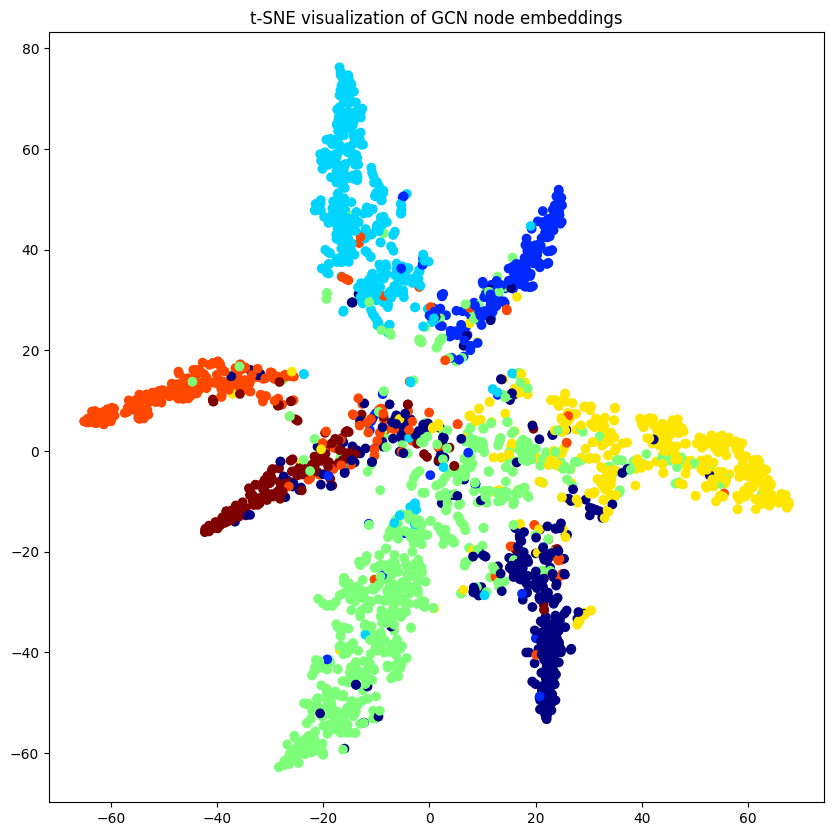

In [6]:
import torch
from torch_geometric.datasets import Planetoid
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load the Cora dataset
dataset = Planetoid(root='.', name='Cora')
data = dataset[0] # Get the first and only graph object

# Print some information about the graph
print(f'Dataset: {dataset.name}')
print('-----------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes (papers): {data.num_nodes}')
print(f'Number of edges (citations): {data.num_edges}')
print(f'Number of features per node (word vector): {dataset.num_node_features}')
print(f'Number of classes (paper topics): {dataset.num_classes}')

print('\nInspect the data object:')
print(data)

print("------------------------------------------")

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # First GCN layer: maps node features to a 16-dimensional hidden space
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        # Second GCN layer: maps the hidden space to the number of classes (7)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        # Unpack the data object
        x, edge_index = data.x, data.edge_index

        # 1. First GCN layer + ReLU activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # Apply dropout to prevent overfitting
        x = F.dropout(x, training=self.training)

        # 2. Second GCN layer
        x = self.conv2(x, edge_index)

        # 3. Apply a softmax to get probabilities
        return F.log_softmax(x, dim=1)

# Let's create an instance of our model
model = GCN()
print(model)

print("------------------------------------------")

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train() # Set the model to training mode

for epoch in range(200):
    optimizer.zero_grad() # Clear old gradients

    # Perform a single forward pass
    out = model(data)

    # Compute the loss ONLY on the training nodes
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])

    # Derive gradients
    loss.backward()

    # Update parameters based on gradients
    optimizer.step()

    if epoch % 20 == 0:
        print(f'Epoch {epoch:03d}, Loss: {loss:.4f}')

print("------------------------------------------")

# Set the model to evaluation mode
model.eval()
pred = model(data).argmax(dim=1) # Get the class with the highest probability

# Check accuracy on the test set
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'\nAccuracy on the test set: {acc:.4f}')

print("------------------------------------------")

# Get the final node embeddings from our trained model
model.eval()
out = model(data)

# Use t-SNE to project embeddings to 2D
tsne = TSNE(n_components=2, random_state=42)
out_2d = tsne.fit_transform(out.detach().numpy())

# Plot the 2D embeddings
plt.figure(figsize=(10, 10))
plt.scatter(out_2d[:, 0], out_2d[:, 1], c=data.y, cmap='jet')
plt.title('t-SNE visualization of GCN node embeddings')
plt.show()